## Scott Breitbach
### DSC530: Week 11
### Assignment 11.2
### 08-November-2020

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

In [2]:
import survival

resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

### Exercise 13-1

**Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing.

In [3]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [4]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry==1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry==1]


Estimate the hazard and survival curve for the duration of marriage.

In [5]:
from collections import Counter

def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts, dtype='float')
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

In [6]:
def HazardCurve(married):
    complete = married[married.notdivorced==0].duration.dropna()
    ongoing = married[married.notdivorced==1].durationsofar.dropna()
    
    # Plot Hazard Curve
    hf = EstimateHazardFunction(complete, ongoing)
    thinkplot.Plot(hf)
    thinkplot.Config(xlabel='Married (years)',
                 ylabel='Hazard')
    
def SurvivalCurve(married):
    complete = married[married.notdivorced==0].duration.dropna()
    ongoing = married[married.notdivorced==1].durationsofar.dropna()
    
    # Plot Survival Curve
    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()
    thinkplot.Plot(sf)
    thinkplot.Config(xlabel='Married (years)',
                 ylabel='Prob still married',
                 ylim=[0, 1])

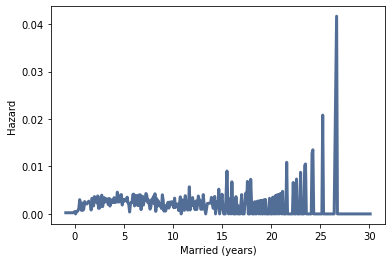

In [7]:
HazardCurve(married6)

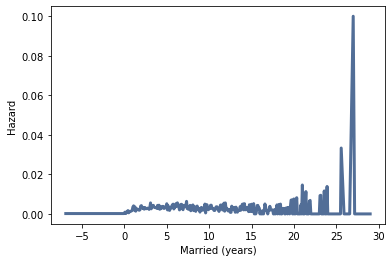

In [8]:
HazardCurve(married7)

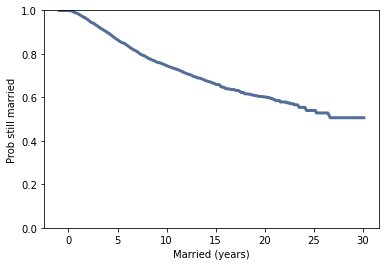

In [9]:
SurvivalCurve(married6)

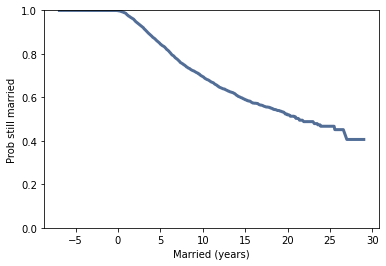

In [10]:
SurvivalCurve(married7)

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

In [11]:
def EstimateMarriageDuration(married):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    complete = married[married.notdivorced==0].duration.dropna()
    ongoing = married[married.notdivorced==1].durationsofar.dropna()

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [12]:
def ResampleDuration(resp, iters=101):
    """Resamples respondents and estimates the survival function.

    resp: DataFrame of respondents
    iters: number of resamples
    """ 
    _, sf = EstimateMarriageDuration(resp)
    thinkplot.Plot(sf)

    low, high = resp.duration.min(), resp.duration.max()
    ts = np.arange(low, high, 1/12.0)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageDuration(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='gray', label='90% CI')

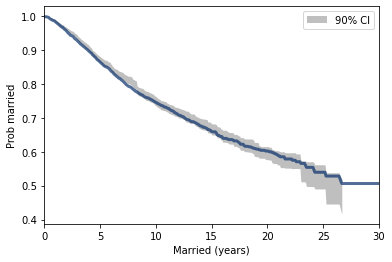

In [13]:
ResampleDuration(married6)
thinkplot.Config(xlabel='Married (years)',
                 ylabel='Prob married',
                 xlim=[0, 30],
                 loc='upper right')

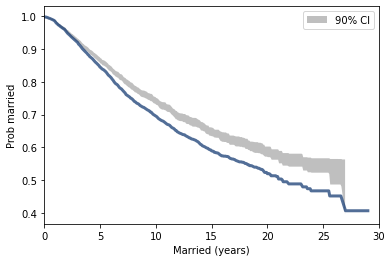

In [14]:
ResampleDuration(married7)
thinkplot.Config(xlabel='Married (years)',
                 ylabel='Prob married',
                 xlim=[0, 30],
                 loc='upper right')

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [15]:
def AddLabelsByDecade(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = '%d0s' % name
        thinkplot.Plot([15], [1], label=label, **options)

def EstimateMarriageDuration(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

def EstimateMarriageDurationByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateMarriageDuration(group)
        thinkplot.Plot(sf, **options)

def PlotResampledByDecade(resps, iters=41, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')

        if omit:
            groups = [(name, group) for name, group in groups 
                      if name not in omit]

        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageDurationByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageDurationByDecade(groups, alpha=0.2)
        
    thinkplot.Config(xlabel='Married (years)',
                   ylabel='Prob married',
                   xlim=[0, 30],
                   ylim=[0, 1])

In [16]:
marriedAll = [married6, married7]

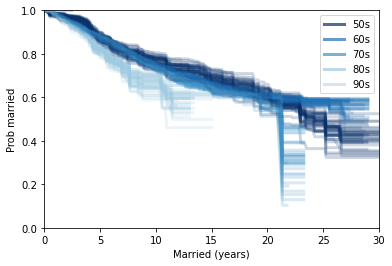

In [17]:
PlotResampledByDecade(marriedAll)